# attempt to detect ticked/unticked and circled/not-circled images using openCV

In [ ]:
import importlib
import main
import os
importlib.reload(main)
from main import *
folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]


def list_files_in_folder(folder_path, ext=None):
    """
    Returns a list of file names in the given folder, optionally filtering by extension.
    
    Parameters:
        folder_path (str): The path to the folder.
        ext (str, optional): The file extension to filter by (e.g., 'png'). Defaults to None.
        
    Returns:
        list: A list of file names matching the extension.
    """
    try:
        # List all files in the directory
        files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]
        
        if ext is not None:
            # Normalize the extension to lowercase
            ext = ext.lower()
            # Filter files by extension (case-insensitive)
            files = [
                f for f in files
                if os.path.splitext(f)[1].lower() == f'.{ext}'
            ]
        
        return files
    
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")
        return []
    



threshold = 60  # Set your desired threshold

folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]
for folder in folder_list:
    image_paths = list_files_in_folder(folder,ext="PNG")

    print(folder)
    for file_name in image_paths:
        full_file_path = os.path.join(folder, file_name)

        filename = full_file_path.split("/")[-1]
        name = filename.split(".")[0]
        unique_strings = [
        "no1_93",
        "no1_86",
        "yes1_2",
        "no1_96",
        "no1_97",
        "yes1_79",
        "no1_27",
        "no1_2",
        "no4",
        "no1_71",
        "yes1_60",
        "no1_22"
    ]

        # if name  in unique_strings:
        if name  in unique_strings or 1:
        # break   

            result_payload = process_image(full_file_path, threshold=threshold, show_plots=False)
            LOGGER.info(result_payload)



            # Save the resulting images with green or red text
            output_directory = 'results'
            file_name_prefix = os.path.splitext(os.path.basename(filename))[0]  # Use the original file name as prefix
            image = cv2.imread(full_file_path)
            annotated_image_path = annotate_image_openCV(
                image=image,
                result_payload=result_payload,
                output_path=output_directory,
                file_name_prefix=file_name_prefix,
        )

        

In [3]:
# epsilon_values = [0.01, 0.02, 0.03, 0.05]

# for epsilon_multiplier in epsilon_values:
#     print(f"\nTesting with epsilon_multiplier = {epsilon_multiplier}")
#     tick_detected, detection_info = detect_checkbox_with_tick(
#         gray,
#         area_threshold=100,
#         epsilon_multiplier=epsilon_multiplier,
#         debug=True,
#         show_plots=True
#     )

In [4]:
# param_ranges = {
#     'clahe_clip_limits': [1.0, 1.5, 2.0],
#     'tile_grid_sizes': [(4, 4), (8, 8)],
#     'block_sizes': [15, 21, 31],  # Must be odd numbers
#     'C_values': [2, 3, 5],
#     'area_thresholds': [50, 100, 200]
# }
# full_file_path = "dataset/images_test/no1_93.PNG"
# explore_detection_parameters(full_file_path, param_ranges)

# attempt to use a CNN model and identity detect ticked/unticked and circled/not-circled images

## training the model

loading images from dataset
folder path is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/
.DS_Store
ticked
circled_yes
circled_no
unticked
labelling images
Split data into training and testing
create CNN model
compiling the model
training the model
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.3219 - loss: 1.4902 - val_accuracy: 0.4909 - val_loss: 1.2629
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 461ms/step - accuracy: 0.5693 - loss: 1.1346 - val_accuracy: 0.7273 - val_loss: 0.8155
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - accuracy: 0.7384 - loss: 0.7723 - val_accuracy: 0.6909 - val_loss: 0.7012
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.7842 - loss: 0.5864 - val_accuracy: 0.7455 - val_loss: 0.5850
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.8686 - loss: 0.3668 - val_accuracy: 0.8364 - val_loss: 0.4903
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - accuracy: 0.9293 - loss: 0.2306 - val_accuracy: 0.7818 -

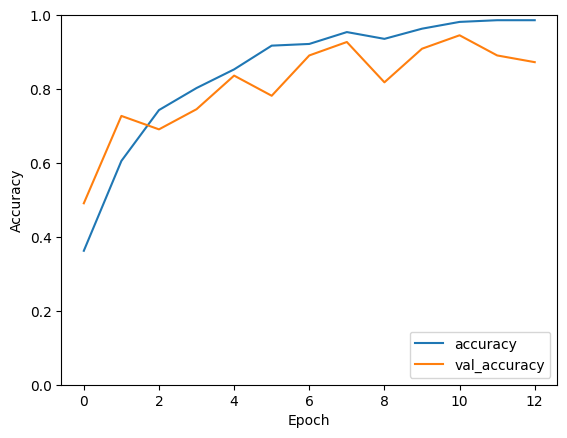

2/2 - 0s - 126ms/step - accuracy: 0.8727 - loss: 0.5208
Test accuracy: 0.8727272748947144


In [27]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess images
def load_images_from_folder(folder):
    current_dir = os.getcwd()
    folder_path = os.path.join(current_dir, folder)
    print(f"folder path is {folder_path}")
    images = []
    labels = []
    
    if not os.path.isdir(folder_path):
        raise ValueError(f"Folder {folder_path} does not exist.")
    
    for label in os.listdir(folder_path):
        print(label)
        label_folder = os.path.join(folder_path, label)
        if not os.path.isdir(label_folder):
            continue
        
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            if img is not None:
                img = cv2.resize(img, (80, 140))  # Resize to 80x140 (width x height) for the model
                images.append(img)
                labels.append(label)
    
    return np.array(images), np.array(labels)


# Load data
print("loading images from dataset")
image_data, labels = load_images_from_folder('dataset/')
image_data = image_data.reshape(-1, 140, 80, 1)  # Add channel dimension for grayscale
image_data = image_data / 255.0  # Normalize the pixel values
# print(f"found these labels {labels}")


# Convert labels to integers (e.g., ticked=0, unticked=1, yes=2, no=3)
print("labelling images")
label_mapping = {'ticked': 0, 'unticked': 1, 'circled_yes': 2, 'circled_no': 3}
labels = np.array([label_mapping[label] for label in labels])


# Split data into training and testing
print("Split data into training and testing")
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

# Create the CNN model
print("create CNN model")
model = models.Sequential()

# First convolution layer with updated input shape
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(140, 80, 1)))  # Updated input shape
model.add(layers.MaxPooling2D((2, 2)))

# Second convolution layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third convolution layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))  # 4 classes: ticked, unticked, circled_yes, circled_no

# Compile the model
print("compiling the model")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("training the model")
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])



# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')


## saving the model

In [30]:
# model.save('ticked_box_model.h5')
model.save('ticked_box_model.keras')

## load the model

In [98]:


# Load the trained model globally so it's available in subsequent requests
model = tf.keras.models.load_model('ticked_box_model.keras')
print(type(model))



<class 'keras.src.models.sequential.Sequential'>


/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


## predict

In [99]:
import importlib
import main
import os
importlib.reload(main)
from main import *

In [100]:
from io import BytesIO
folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]
threshold = 0.6  
for folder in folder_list:
    image_paths = list_files_in_folder(folder,ext="PNG")

    print(folder)
    for file_name in image_paths:
        print()
        full_file_path = os.path.join(folder, file_name)
        print(f"processing image {full_file_path}")
        filename = full_file_path.split("/")[-1]
        image_name = filename.split(".")[0]
        unique_strings = [
        "no1_93",
        "no1_86",
        "yes1_2",
        "no1_96",
        "no1_97",
        "yes1_79",
        "no1_27",
        "no1_2",
        "no4",
        "no1_71",
        "yes1_60",
        "no1_22"
    ]

        # if name  in unique_strings:

        if name  in unique_strings or 1:
        # break   
            try:
                with open(full_file_path, "rb") as image_file:
                     image_bytes = BytesIO(image_file.read())
                    
                result_payload = process_image_with_model(image_bytes, threshold,model)
                # Build consent dictionary
                consent = build_consent(result_payload, threshold)
                
                # Read the image using OpenCV for annotation
                image = cv2.imread(full_file_path)
                if image is None:
                    LOGGER.error("Failed to read the image for annotation.")
                    
                
                # Prepare annotation parameters
                output_directory = 'results_model'
                file_name_prefix = os.path.splitext(os.path.basename(full_file_path))[0]  # Use the original file name as prefix
                
                # Annotate the image
                annotated_image_path = annotate_image(
                    image=image,
                    consent=consent,
                    output_path=output_directory,
                    file_name_prefix=file_name_prefix
                )
                

            
            except Exception as e:
                LOGGER.exception("An unexpected error occurred in the main workflow.")
                
            break
                

dataset/images_test

processing image dataset/images_test/no1_89.PNG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


INFO:main:Raw predictions: ticked 0.983283519744873 - unticked 0.0017334794392809272 - circled_yes 0.004986629821360111 - circled_no 0.009996350854635239
INFO:main:Processed response: {'ticked': 0.983283519744873, 'unticked': 0.0017334794392809272, 'circled_yes': 0.004986629821360111, 'circled_no': 0.009996350854635239}
DEBUG:main:Max label: ticked with confidence: 0.983283519744873
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 98.33}
INFO:main:Annotated image saved to results_model/no1_89_annotated.png


dataset/circled_no

processing image dataset/circled_no/no1_62.PNG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.014899561181664467 - unticked 0.00022242091654334217 - circled_yes 2.359708923904691e-05 - circled_no 0.9848544597625732
INFO:main:Processed response: {'ticked': 0.014899561181664467, 'unticked': 0.00022242091654334217, 'circled_yes': 2.359708923904691e-05, 'circled_no': 0.9848544597625732}
DEBUG:main:Max label: circled_no with confidence: 0.9848544597625732
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 98.49}
INFO:main:Annotated image saved to results_model/no1_62_annotated.png


dataset/circled_yes

processing image dataset/circled_yes/yes1_92.PNG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 2.445796169758818e-12 - unticked 3.308691279399652e-14 - circled_yes 1.0 - circled_no 2.503237072603987e-20
INFO:main:Processed response: {'ticked': 2.445796169758818e-12, 'unticked': 3.308691279399652e-14, 'circled_yes': 1.0, 'circled_no': 2.503237072603987e-20}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_92_annotated.png


dataset/unticked

processing image dataset/unticked/no1_76.PNG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.14509479701519012 - unticked 0.8548911213874817 - circled_yes 1.397153300786158e-05 - circled_no 9.183495564002442e-08
INFO:main:Processed response: {'ticked': 0.14509479701519012, 'unticked': 0.8548911213874817, 'circled_yes': 1.397153300786158e-05, 'circled_no': 9.183495564002442e-08}
DEBUG:main:Max label: unticked with confidence: 0.8548911213874817
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 85.49}
INFO:main:Annotated image saved to results_model/no1_76_annotated.png


dataset/ticked

processing image dataset/ticked/no1_89.PNG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.983283519744873 - unticked 0.0017334794392809272 - circled_yes 0.004986629821360111 - circled_no 0.009996350854635239
INFO:main:Processed response: {'ticked': 0.983283519744873, 'unticked': 0.0017334794392809272, 'circled_yes': 0.004986629821360111, 'circled_no': 0.009996350854635239}
DEBUG:main:Max label: ticked with confidence: 0.983283519744873
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 98.33}
INFO:main:Annotated image saved to results_model/no1_89_annotated.png
